# File Preprocessing  

In [1]:
import pandas as pd
import numpy as np
import cv2
from pathlib import Path
import os
import shutil
from glob import glob
import matplotlib.pyplot as plt

In [2]:
cwd_path = Path.cwd()

In [3]:
og_train_path = os.path.join(cwd_path, "ML_FINAL_PROJECT/fruits-360/Training")
og_test_path  = os.path.join(cwd_path, "ML_FINAL_PROJECT/fruits-360/Test")

In [4]:
def getRandomFruitDirs(classCount):
    return np.random.choice(os.listdir(og_train_path), classCount, replace=False)

In [5]:
def MakeDirs(srcDir, newDirs):
    
    if type(newDirs) == str: 
        dirpath = os.path.join(srcDir, newDirs)
        if os.path.isdir(dirpath): 
            shutil.rmtree(dirpath)
        
        os.mkdir(dirpath)
    
    
    if type(newDirs) == list:    
        for dirname in newDirs:
            dirpath = os.path.join(srcDir, dirname)
            if os.path.isdir(dirpath):
                shutil.rmtree(dirpath)
        
            os.mkdir(dirpath)

In [6]:
def transferFile(srcPaths, destDir):
    if not os.path.isdir(destDir):     
        os.mkdir(destDir)
        
    for idx, imagePth in enumerate(srcPaths): 
        dPath = os.path.join(destDir, f"img{idx}.jpg")
        os.symlink(imagePth, dPath)
    

In [7]:
def getImageMatrix(links, title, image_size):

    sub_matrix = np.zeros(image_size[0] * image_size[1] * 3)
    labels = []
    for link in links: 
        vect_item = cv2.imread(link)
        vect_item = cv2.resize(vect_item, image_size)
        vect_item = cv2.cvtColor(vect_item, cv2.COLOR_BGR2RGB)
        sub_matrix = np.vstack((sub_matrix, vect_item.flatten()))
        labels.append(title)
        
    return sub_matrix[1:]/255, np.array(labels)

In [33]:
def getSamplesDir(sampleSize, valSize, testSize, selectedFruits, classDist = None): 
    trainSize = 1 - (valSize + testSize)
    train_fn = []
    test_fn = []
    val_fn = []

    if classDist is None: 
        cDist = np.ones(selectedFruits.shape[0]) * 1/selectedFruits.shape[0]
    else: 
        cDist = classDist
    
    if np.abs(np.sum(cDist) - 1) > 1e-9:
        raise Exception("Class Distribution is greater than one!")

        
    if testSize <= 0: 
        raise Exception("Training sample size too small!")

    train_sample_sz = int(trainSize * sampleSize)
    val_sample_sz = int(valSize * sampleSize) 
    test_sample_sz = int(testSize * sampleSize)

    subset_dir = "ML_FINAL_PROJECT/fruits-360"
    MakeDirs(subset_dir, "Subsets")
    
    subset_dir = "ML_FINAL_PROJECT/fruits-360/Subsets"
    
    subs = ["Train_sub", "Validation_sub", "Test_sub"]
    MakeDirs("ML_FINAL_PROJECT/fruits-360/Subsets", subs)

    for idx, fruit in enumerate(selectedFruits): 
        globbed_train = glob(os.path.join(og_train_path, fruit, "*.jp*g"))
        globbed_test = glob(os.path.join(og_test_path, fruit, "*.jp*g"))
        
        train_fn = np.random.choice(globbed_train, int(train_sample_sz * cDist[idx]), replace = False)
        testval_fn = np.random.choice(globbed_test, int((test_sample_sz  + val_sample_sz)*cDist[idx]), replace = False)

        test_fn, val_fn = testval_fn[ : int(test_sample_sz * cDist[idx])],  testval_fn[int(test_sample_sz * cDist[idx]) + 1 :]
        
        transferFile(train_fn, os.path.join(subset_dir, subs[0], fruit))
        transferFile(val_fn, os.path.join(subset_dir, subs[1], fruit))
        transferFile(test_fn, os.path.join(subset_dir, subs[2], fruit)) 

In [34]:
def getSamplesMat(sampleSize, selectedFruits, classDist = None, resize = (100, 100)): 
    matrix = np.zeros(shape = (1, resize[0] * resize[1] * 3))
    labels = np.zeros(0)

    if classDist is None: 
        cDist = np.ones(selectedFruits.shape[0]) * 1/selectedFruits.shape[0]
    else: 
        cDist = classDist
    
    if np.abs(np.sum(cDist) - 1) > 1e-9:
        raise Exception("Class Distribution is greater than one!")
        return 
        

    for idx, fruit in enumerate(selectedFruits): 
        globbed_train = glob(os.path.join(og_train_path, fruit, "*.jp*g"))
        globbed_test = glob(os.path.join(og_test_path, fruit, "*.jp*g"))

        if(len(globbed_train + globbed_test) > 0):  

            fn = np.random.choice(globbed_train + globbed_test, int(sampleSize * cDist[idx]) ,replace = False)
            res_matrix, new_labels = getImageMatrix(fn, fruit,resize)        

            
            matrix = np.vstack([matrix, res_matrix])
            labels = np.concatenate([labels, new_labels])
        else: 
             print("Could not find fruit: ", fruit)
        
        
    return matrix[1:], labels, fn[0]

In [35]:
# Assumes dataset is already color and square
def GrayScaleImageSquare(dataset, flatten=True): 

    if len(dataset.shape) == 2:      
        try: 
            dim = int(np.floor(np.sqrt(dataset.shape[1]/3)))
        except: 
            raise Exception("Singular images may not work, use reshape(-1)")
    
        
        try: 
            dataset = dataset.reshape(-1, dim, dim, 3)
        except: 
            raise Exception("Input image is probably not colored")
    elif len(dataset.shape) == 4: 
        dim = dataset.shape[1]
                           
    grayConv = np.zeros(shape = [dataset.shape[0], dim, dim]); 
    for idx, image in enumerate(dataset): 
        gray_image = cv2.cvtColor(image.astype('float32'), cv2.COLOR_BGR2GRAY)
        grayConv[idx] = gray_image

    if flatten == True: 
        grayConv = grayConv.reshape(-1, dim**2)
        
    return grayConv

In [36]:
def AddNoise(originalImage, strength = 1): 
    randomNoise = np.random.randn(*originalImage.shape)
    new_img = originalImage + (randomNoise * strength)
    return new_img/np.max(new_img)

In [37]:
def LeakageCheck(X_train, X_test):
    similarity_list = []
    for train_image in X_train: 
        for test_image in X_test: 
           if np.sum(((train_image != test_image)).astype(float)) == 0:
               #print("Leaked Image Found")
               similarity_list.append((train_image, test_image))
               
    return similarity_list
            
    

# Exploratory Data Analysis 1: Getting Color Statistics 

In [38]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

In [39]:
# Get all the fruits
total_fruit_list = getRandomFruitDirs(13)
mean_resizes = (30,30)
sample_size = 2000
classDist = None

In [40]:
total_fruit_list

array(['Cocos', 'Cherry Wax Yellow', 'Onion Red', 'Cherry Rainier',
       'Plum 2', 'Grape White 3', 'Granadilla', 'Redcurrant', 'Tomato 3',
       'Cherry 2', 'Apple Red 1', 'Salak', 'Kohlrabi'], dtype='<U19')

In [41]:
fruits = total_fruit_list
image_dataset, labels, what = getSamplesMat(sample_size, total_fruit_list, classDist, mean_resizes)

In [42]:
image_dataset.shape

(1989, 2700)

In [50]:
def GetColorStatistics(image_dataset): 
    mean_color = []
    for idx, image in enumerate(image_dataset): 
        # Zero all white points
        #image[image == 1] = np.array([0,0,0])
        pixel_cnt = int(np.sqrt(image.shape[0]/3))
        image = image.reshape(pixel_cnt * pixel_cnt, 3)
        mean_color.append(np.mean(image, axis=0))
    return np.array(mean_color)
  

In [51]:
mean_color = GetColorStatistics(image_dataset)

Text(0.5, 0.98, 'Title: Plum 2')

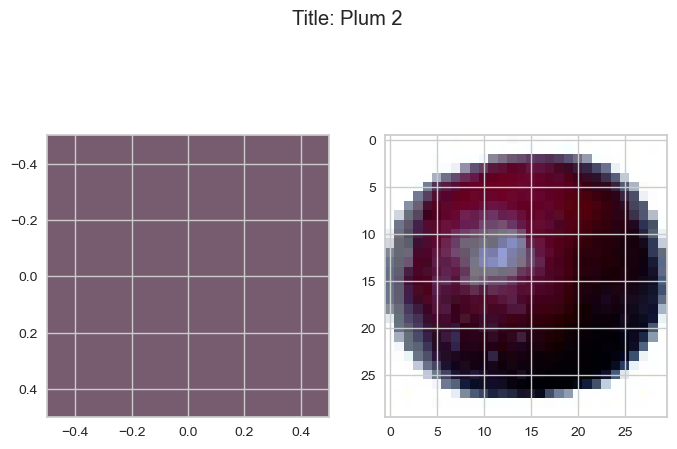

In [52]:
# Demonstration of mean shape: 
fig, ax = plt.subplots(nrows = 1, ncols = 2)
index = np.random.randint(0, 1430)
ax[0].imshow(mean_color[index].reshape(1,1,3))
ax[1].imshow(image_dataset[index].reshape(mean_resizes[0],mean_resizes[1],3))
fig.suptitle(f"Title: {labels[index]}")

In [53]:
KmeansColor = KMeans(n_init = 20)

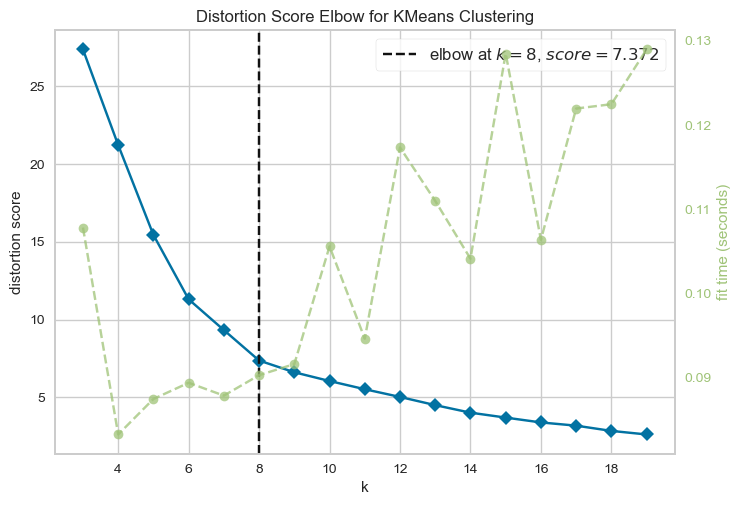

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [54]:
# run the KElbow: 
visualizer = KElbowVisualizer(KmeansColor, k=(3, 20))
visualizer.fit(mean_color)     
visualizer.show() 

In [55]:
KMeansColor = KMeans(n_clusters=15, n_init=20)

In [56]:
KMeansColor.fit(mean_color)

KMeans(n_clusters=15, n_init=20)

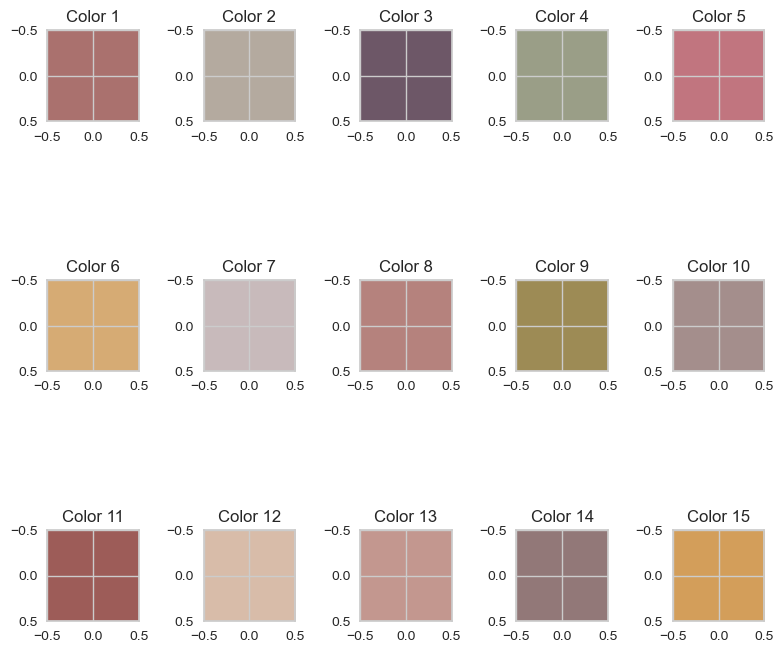

In [57]:
centers = KMeansColor.cluster_centers_
cluster_cnt = len(centers)
cols = 5
rows = int(np.ceil(cluster_cnt/cols))

fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(8, 8))

for idx in range(cluster_cnt):
    ax[idx//5][idx%5].set_title(f"Color {idx+1}")
    ax[idx//5][idx%5].imshow(centers[idx].reshape(1,1,3))
fig.tight_layout()

In [58]:
cat_labels = KMeansColor.labels_


In [59]:
def GetLabelStatistics(image_dataset, labels, KMeansModel):
    cat_labels = KMeansColor.labels_
    catClassDict = {}
    
    for cat in np.unique(cat_labels):
        cat_indicies = np.where(cat_labels == cat)
        entry = {"Classes" : pd.Series(labels[cat_indicies]).value_counts(), 
         "Indicies" : cat_indicies} 
        catClassDict[cat] = entry
    
    return catClassDict

In [60]:
data_dict = GetLabelStatistics(image_dataset, labels, KMeansColor)

In [61]:
class_num = 5

In [62]:
data_dict[class_num]['Classes']

Cherry Wax Yellow    65
Name: count, dtype: int64

Text(0.5, 1.0, 'Sample image from class 5')

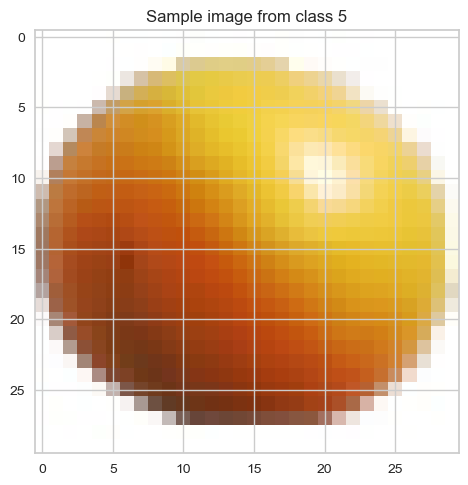

In [63]:
random_img_idx = 13
test_img = data_dict[class_num]['Indicies'][0][random_img_idx]
plt.imshow(image_dataset[test_img].reshape(mean_resizes[0],mean_resizes[1],3))
plt.title(f"Sample image from class {class_num}")

# EDA 2: Exploring Different Prominent Colors

In [350]:
forced_color = [0, 0, 0]
# gets the mean color of a class
def GetClassMeanColor(ClassName, sample_size = 100, resizes = (20, 20)):
    class_list = np.array([ClassName])
    images = getSamplesMat(sample_size, class_list, None, resizes)[0]
    images = images.reshape(-1,  3)
    imgMeanColor = np.mean(images, axis=0)
    return imgMeanColor
  

    
# Gets the mean color for all classes and indicies
def GetAllClassColors(fruit_list): 
    classColors = []
    for fruit in fruit_list: 
        mean_color = GetClassMeanColor(fruit, sample_size = 50)
        classColors.append(mean_color)
    return np.array(classColors)


# Finds ans sort target distances from each color using the top 20 examples: 
def SortByDistance(classVectors, target):
    target = np.tile(target/255, (ClassColors.shape[0], 1))
    diff_vector = np.linalg.norm(classVectors - target, axis=1)
    top_20_idx = diff_vector.argsort()[:20]
    c20mean = np.mean(classVectors[top_20_idx], axis=0)
    cent_dist_vector = np.linalg.norm(classVectors[top_20_idx] - np.tile(c20mean, (20, 1)))
    return top_20_idx, cent_dist_vector




# Puts everything together to get the overall target colors: 
def FindMostPromenentColors(fruitList, target_dict):
    ClassColors = GetAllClassColors(fruitList)
    Color_Params = {} 
    for cname, cval in target_dict.items(): 
        top_20_idx, dist_20 = SortByDistance(ClassColors, np.array(cval))
        Info_Json = {"Classes" : fruitList[top_20_idx], "Centroid Distance" : dist_20, "CVal":cval}
        Color_Params[cname] = Info_Json
    return Color_Params

# Usage: you can add Colors in the target Colors section in the RBG format (integers 0-255) and run the cell

In [362]:
total_fruit_list = getRandomFruitDirs(130)
fruity = total_fruit_list[total_fruit_list  != '.ipynb_checkpoints']
TargetColors = {'Red' : np.array([255, 0, 0]), 'Green' : np.array([0, 255, 0]), 'Blue' : np.array([0, 0, 255])}

# The lower the centroid distance the more compact the mean colors of each class in color category is: 
FindMostPromenentColors(fruity, TargetColors)

{'Red': {'Classes': array(['Tomato Cherry Red', 'Tomato 4', 'Tomato 1', 'Orange',
         'Pepper Red', 'Nectarine', 'Apple Braeburn', 'Apricot',
         'Pepper Yellow', 'Cherry Wax Red', 'Clementine', 'Tomato Heart',
         'Tomato Yellow', 'Peach', 'Pepper Orange', 'Pomegranate',
         'Tomato 3', 'Nut Forest', 'Apple Red Yellow 1', 'Apple Red 2'],
        dtype='<U19'),
  'Centroid Distance': 0.6169123988489028,
  'CVal': array([255,   0,   0])},
 'Green': {'Classes': array(['Pepper Green', 'Grape White 4', 'Grape Blue',
         'Tomato not Ripened', 'Cherry Wax Black', 'Grape White 3',
         'Avocado', 'Cherry 1', 'Blueberry', 'Plum', 'Nut Forest', 'Plum 3',
         'Mango', 'Limes', 'Pomelo Sweetie', 'Guava', 'Pineapple',
         'Apple Golden 3', 'Watermelon', 'Plum 2'], dtype='<U19'),
  'Centroid Distance': 0.7784238022780292,
  'CVal': array([  0, 255,   0])},
 'Blue': {'Classes': array(['Huckleberry', 'Grape Blue', 'Plum 2', 'Cherry Wax Black',
         'Blueberr

# (OLD) Testing the SVM Methods: 

In [75]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split


In [126]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

sample_size = 1500
classDist = None
resizes = (20,20)


#Testing Lemon and corn
fruits = ["Lemon", "Corn"]
fruits = np.array(fruits)
image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels, test_size=0.2, shuffle=True, random_state=42)


# Checking for leaked Images
LeakedImages = LeakageCheck(X_train, X_test)
print("Number of leaked images: ", len(LeakedImages))

# Adding random noise: 
X_train = AddNoise(X_train, 0.1)
X_test = AddNoise(X_test, 0.1)

rbf_svm = SVC(kernel='rbf', C=1, gamma='scale')
rbf_svm.fit(X_train, y_train)
y_pred_rbf = rbf_svm.predict(X_test)
print(classification_report(y_test, y_pred_rbf))
cm = confusion_matrix(y_test, y_pred_rbf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

ValueError: Cannot take a larger sample than population when 'replace=False'

In [41]:
index = np.random.randint(0, 100)
plt.imshow(X_train[index].reshape(20,20,3))
plt.title(y_train[index])

NameError: name 'X_train' is not defined

In [42]:
#Testing Eggplant and Plum
fruits = ["Eggplant", "Plum"]
fruits = np.array(fruits)
image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)

X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels, test_size=0.2, random_state=42)

LeakedImages = LeakageCheck(X_train, X_test)
print("Number of leaked images: ", len(LeakedImages))

# Adding random noise: 
X_train = AddNoise(X_train, 1.0)
X_test = AddNoise(X_test, 1.0)



rbf_svm = SVC(kernel='rbf', C=1, gamma='scale')
rbf_svm.fit(X_train, y_train)
y_pred_rbf = rbf_svm.predict(X_test)
print(classification_report(y_test, y_pred_rbf))
cm = confusion_matrix(y_test, y_pred_rbf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Could not find fruit:  Eggplant


UnboundLocalError: cannot access local variable 'res_matrix' where it is not associated with a value

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Plum')

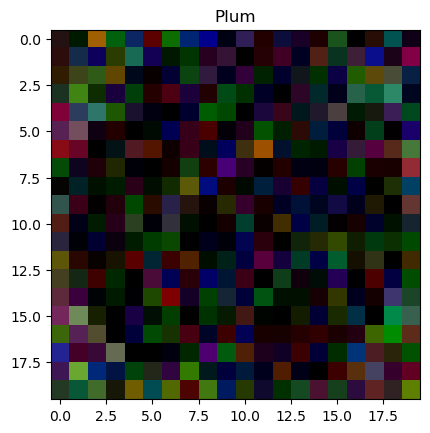

In [31]:
index = np.random.randint(0, 100)
plt.imshow(X_train[index].reshape(20,20,3))
plt.title(y_train[index])

Number of leaked images:  0
                precision    recall  f1-score   support

Apple Golden 1       1.00      1.00      1.00        17
   Apple Red 2       1.00      1.00      1.00         7
        Banana       1.00      1.00      1.00         9
    Pepper Red       1.00      1.00      1.00        16
    Strawberry       1.00      1.00      1.00        11

      accuracy                           1.00        60
     macro avg       1.00      1.00      1.00        60
  weighted avg       1.00      1.00      1.00        60



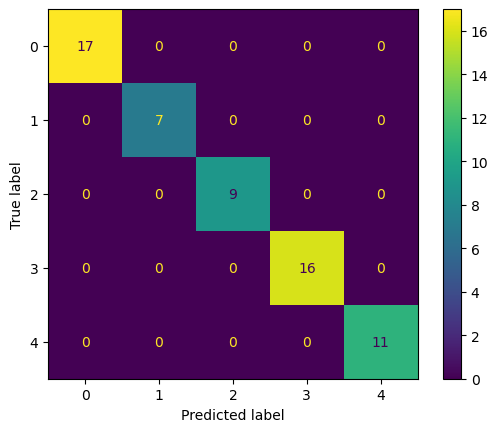

In [100]:
#Testing Lemon and corn
fruits = ["Strawberry", "Pepper Red", "Apple Red 2", "Apple Golden 1", "Banana"]
fruits = np.array(fruits)
image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)

X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels, shuffle=True, test_size=0.2, random_state=42)

X_train = GrayScaleImageSquare(X_train)
X_test = GrayScaleImageSquare(X_test)

LeakedImages = LeakageCheck(X_train, X_test)
print("Number of leaked images: ", len(LeakedImages))


rbf_svm = SVC(kernel='rbf', C=1, gamma='scale')
rbf_svm.fit(X_train, y_train)
y_pred_rbf = rbf_svm.predict(X_test)
print(classification_report(y_test, y_pred_rbf))
cm = confusion_matrix(y_test, y_pred_rbf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# SVM's
## Testing similar color but different shapes

## Testing similar shape but different colors

Number of leaked images:  0
              precision    recall  f1-score   support

   Onion Red       1.00      1.00      1.00        29
 Onion White       1.00      1.00      1.00        31

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



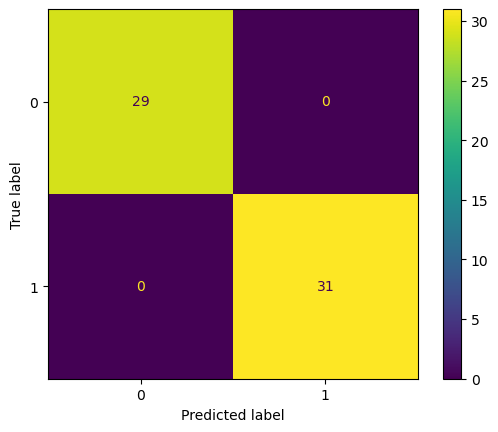

In [73]:
#Testing onion red and onion white
fruits = ["Onion Red", "Onion White"]
fruits = np.array(fruits)
image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)

X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels, test_size=0.2, random_state=42)

X_train = GrayScaleImageSquare(X_train)
X_test = GrayScaleImageSquare(X_test)


LeakedImages = LeakageCheck(X_train, X_test)
print("Number of leaked images: ", len(LeakedImages))



rbf_svm = SVC(kernel='rbf', C=1, gamma='scale')
rbf_svm.fit(X_train, y_train)
y_pred_rbf = rbf_svm.predict(X_test)
print(classification_report(y_test, y_pred_rbf))
cm = confusion_matrix(y_test, y_pred_rbf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Number of leaked images:  0
              precision    recall  f1-score   support

Pepper Green       1.00      1.00      1.00        27
  Pepper Red       1.00      1.00      1.00        33

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



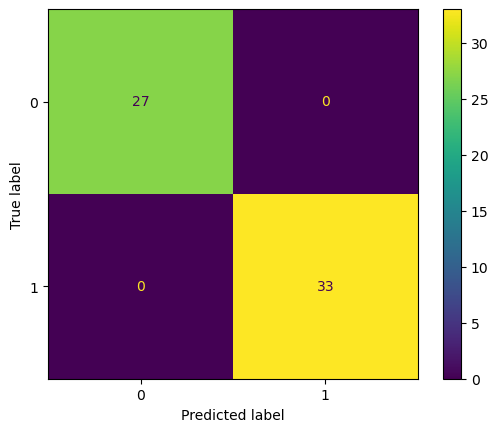

In [75]:
#Testing pepper green and pepper red
fruits = ["Pepper Green", "Pepper Red"]
fruits = np.array(fruits)
image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)

X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels, test_size=0.2, shuffle=True)


LeakedImages = LeakageCheck(X_train, X_test)
print("Number of leaked images: ", len(LeakedImages))



rbf_svm = SVC(kernel='rbf', C=1, gamma='scale')
rbf_svm.fit(X_train, y_train)
y_pred_rbf = rbf_svm.predict(X_test)
print(classification_report(y_test, y_pred_rbf))
cm = confusion_matrix(y_test, y_pred_rbf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

(240, 400)
(60, 400)
              precision    recall  f1-score   support

Cantaloupe 1       1.00      1.00      1.00        22
      Walnut       1.00      1.00      1.00        16
  Watermelon       1.00      1.00      1.00        22

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



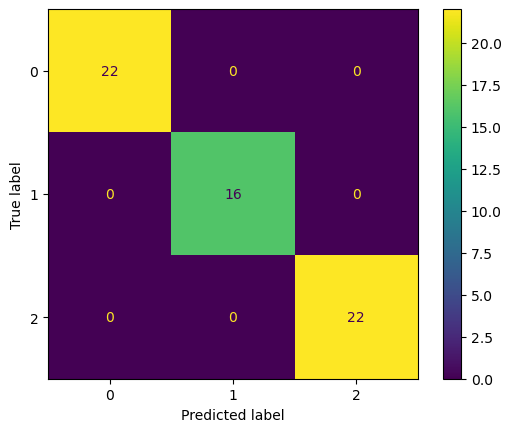

In [249]:
#Testing Cantaloupe 1, Walnut, and Watermelon
fruits = ["Cantaloupe 1", "Walnut", "Watermelon"]
fruits = np.array(fruits)
image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)

X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels, test_size=0.2, random_state=42)

X_train = GrayScaleImageSquare(X_train)
X_test = GrayScaleImageSquare(X_test)

print(X_train.shape)
print(X_test.shape)

rbf_svm = SVC(kernel='rbf', C=1, gamma='scale')
rbf_svm.fit(X_train, y_train)
y_pred_rbf = rbf_svm.predict(X_test)
print(classification_report(y_test, y_pred_rbf))
cm = confusion_matrix(y_test, y_pred_rbf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## Very similar fruits

(240, 400)
(60, 400)
                   precision    recall  f1-score   support

         Cherry 2       1.00      1.00      1.00        31
Tomato Cherry Red       1.00      1.00      1.00        29

         accuracy                           1.00        60
        macro avg       1.00      1.00      1.00        60
     weighted avg       1.00      1.00      1.00        60



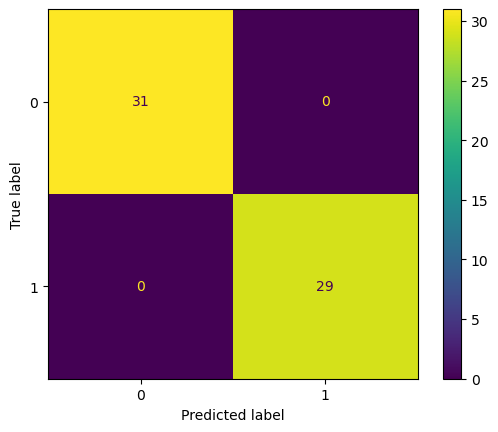

In [250]:
#Testing Tomato Cherry Red, Cherry 2
fruits = ["Tomato Cherry Red", "Cherry 2"]
fruits = np.array(fruits)
image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)

X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels, test_size=0.2, random_state=42)

X_train = GrayScaleImageSquare(X_train)
X_test = GrayScaleImageSquare(X_test)

print(X_train.shape)
print(X_test.shape)

rbf_svm = SVC(kernel='rbf', C=1, gamma='scale')
rbf_svm.fit(X_train, y_train)
y_pred_rbf = rbf_svm.predict(X_test)
print(classification_report(y_test, y_pred_rbf))
cm = confusion_matrix(y_test, y_pred_rbf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

(240, 400)
(60, 400)
              precision    recall  f1-score   support

      Orange       1.00      1.00      1.00        31
    Physalis       1.00      1.00      1.00        29

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



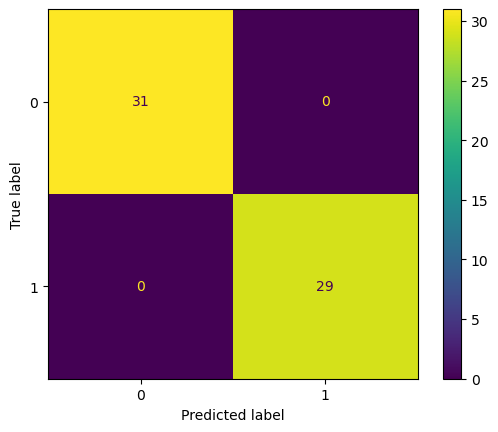

In [251]:
#Testing Physalis and Orange
fruits = ["Physalis", "Orange"]
fruits = np.array(fruits)
image_dataset, labels, what = getSamplesMat(sample_size, fruits, classDist, resizes)

X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels, test_size=0.2, random_state=42)


X_train = GrayScaleImageSquare(X_train)
X_test = GrayScaleImageSquare(X_test)

print(X_train.shape)
print(X_test.shape)

rbf_svm = SVC(kernel='rbf', C=1, gamma='scale')
rbf_svm.fit(X_train, y_train)
y_pred_rbf = rbf_svm.predict(X_test)
print(classification_report(y_test, y_pred_rbf))
cm = confusion_matrix(y_test, y_pred_rbf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

(100, 400)
(48, 400)
                precision    recall  f1-score   support

Apple Golden 1       0.78      0.44      0.56        16
Apple Golden 2       0.86      0.75      0.80        16
Apple Golden 3       0.64      1.00      0.78        16

      accuracy                           0.73        48
     macro avg       0.76      0.73      0.71        48
  weighted avg       0.76      0.73      0.71        48



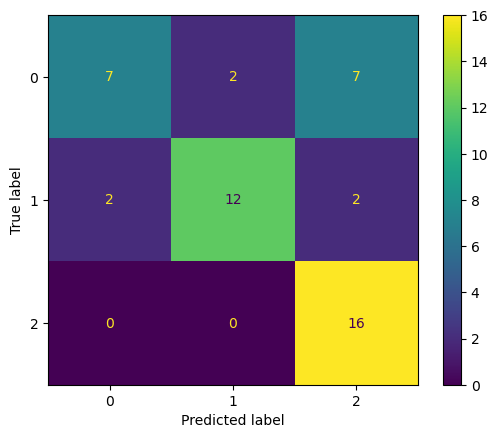

In [320]:
#Testing Apple Golden 1, Apple Golden 2, Apple Golden 3
fruits = ["Apple Golden 1", "Apple Golden 2", "Apple Golden 3"]
fruits = np.array(fruits)
classDistTrain = [0.1, 0.1, 0.8]
classDistTest = None
X_train, y_train, what = getSamplesMat(100, fruits, classDistTrain, resizes)
X_test, y_test, what = getSamplesMat(50, fruits, classDistTest, resizes)

#X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels, test_size=0.50, shuffle=True, random_state=42)


X_train = GrayScaleImageSquare(X_train)
X_test = GrayScaleImageSquare(X_test)

print(X_train.shape)
print(X_test.shape)

rbf_svm = SVC(kernel='rbf', C=1, gamma='scale')
rbf_svm.fit(X_train, y_train)
y_pred_rbf = rbf_svm.predict(X_test)
print(classification_report(y_test, y_pred_rbf))
cm = confusion_matrix(y_test, y_pred_rbf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Text(0.5, 1.0, 'Apple Golden 3')

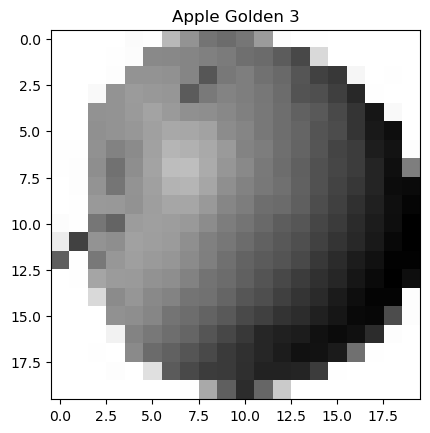

In [314]:
index = 22
plt.imshow(X_test[index].reshape(resizes), cmap='gray')
plt.title(y_test[index])